# Batch running of multiple optimizations in parallel

In the previous tutorials we fit homogeneous and heterogeneous models to the pooled empirical functional data of a single group.

However, we often want to perform multiple optimizations, especially if we are fitting subject-specific (individualized) BNMs. Furthermore, even when fitting the model to data of a single individual or group, we should perform multiple optimization runs using different random seeds to reduce the chance of convergence to local optima.

At the same time, the CMA-ES runs we performed earlier used a relatively number of simulations in parallel (128 particles). Depending on the GPU hardware, this may underutilize the available GPU resources.

To address this, the cuBNM toolbox includes functionality for batch-running multiple optimizations in parallel: across subjects, across runs for the same subject, or both. This helps fully leverage the GPU and improves efficiency compared to running the optimizations independently and serially.

In this tutorial, we'll use this batch optimization functionality to run CMA-ES optimizations of node-based heterogeneous models (based on canonical resting state networks) in parallel for two subjects from the HCP-YA dataset, performing two optimizations (with different sampling seeds) per subject (i.e., a total of four paralllel optimization runs).

## Loading the data

We will use the data of the first two subjects from the HCP-YA dataset. The data of these two subjects (and only these two) is included in the toolbox and can be loaded as follows:

In [1]:
from cubnm import datasets, utils

subjects = ['100206', '100307']

scs = {}
emp_bolds = {}

for sub in subjects:
    scs[sub] = datasets.load_sc('strength', 'schaefer-100', sub)
    emp_bolds[sub] = datasets.load_bold('schaefer-100', sub, ses='REST1_LR')

Let’s fist visualize the SC matrices and BOLD signals:

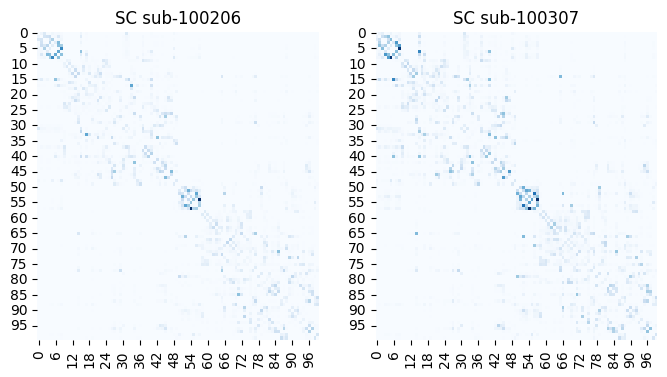

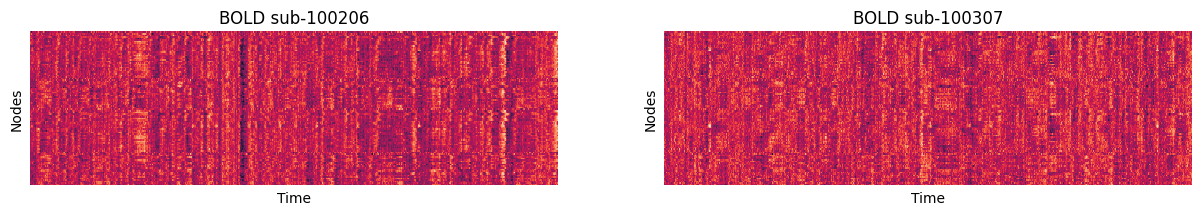

In [2]:
from cubnm import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i_sub, sub in enumerate(subjects):
    sns.heatmap(scs[sub], cmap='Blues', cbar=False, ax=axes[i_sub])
    axes[i_sub].set_title(f"SC sub-{sub}")
    
fig, axes = plt.subplots(1, 2, figsize=(15, 2))
for i_sub, sub in enumerate(subjects):
    ax = axes[i_sub]
    # plot z-scored BOLD signal
    sns.heatmap(scipy.stats.zscore(emp_bolds[sub], axis=1), cbar=False, ax=ax)
    ax.set_ylabel("Nodes")
    ax.set_xlabel("Time")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"BOLD sub-{sub}")

## Running batch optimization

Now we'll create separate `BNMProblem` objects for each subject. These will define heterogeneous rWW models with FIC, similar to the model used in [the node-based heterogeneous CMA-ES tutorial](cmaes_yeo.ipynb). Note that each subject has a different `sc`, `emp_bold`, and `out_dir`, so we pass `sc` directly to the `BNMProblem` instead of including it in `sim_options` dictionary.

In [3]:
import os
from cubnm import optimize

# define simulation options
sim_options = dict(
    duration=900,
    bold_remove_s=30,
    TR=0.72,
    sc_dist=None,
    dt='0.1',
    bw_dt='1.0',
    ext_out=True,
    states_ts=False,
    states_sampling=None,
    noise_out=False,
    sim_seed=0,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=30,
    window_step=5,
    fcd_drop_edges=True,
    exc_interhemispheric=True,
    bw_params='heinzle2016-3T',
    sim_verbose=False,
    do_fic=True,
    max_fic_trials=0,
    fic_penalty_scale=0.5,
)

# load the Yeo networks map
yeo_map = datasets.load_maps('yeo7', parc='schaefer-100').astype(int)[0]

# define a map-based heterogeneous problem for each subject
problems = {}
for sub in subjects:
    problems[sub] = optimize.BNMProblem(
        model = 'rWW',
        params = {
            'G': (0.001, 10.0), 
            'w_p': (0, 2.0),
            'J_N': (0.001, 0.5)
        },
        emp_bold = emp_bolds[sub], # subject-specific bold signal
        sc = scs[sub], # subject-specific SC
        het_params = ['w_p', 'J_N'],
        node_grouping = yeo_map,
        out_dir = os.path.join('./batch_cmaes', sub), # subject-specific output directories
        **sim_options
    )
    
problems

{'100206': <cubnm.optimize.BNMProblem at 0x1457b5fcacb0>,
 '100307': <cubnm.optimize.BNMProblem at 0x1458351d0f70>}

Next, we define two CMA-ES optimizers with different seeds. These will be reused across subjects, and subject-specific copies of the optimizers will be created internally. 

In [4]:
optimizers = {}
for seed in [1, 2]:
    optimizers[seed] = optimize.CMAESOptimizer(
        popsize=128,
        n_iter=120, 
        seed=seed,
        algorithm_kws=dict(tolfun=5e-3),
        print_history=False
    )

optimizers

{1: <cubnm.optimize.CMAESOptimizer at 0x1457b53e7130>,
 2: <cubnm.optimize.CMAESOptimizer at 0x1458351d36a0>}

Note that unlike single-run optimizations, we do not need to call `setup_problem()` as it is handled internally during batch optimization.

We can now run all four optimization runs (2 subjects × 2 seeds) in parallel using the `optimize.batch_optimize()` function. This function takes lists of problems and optimizers corresponding to each run. After running the optimizations, it returns fitted copies of the provided `Optimizer` (e.g. `CMAESOptimizer`) instances.


<div class="alert alert-info">
<p>
Technical Note: Internally, `batch_optimize()` creates a `MultiSimGroup` by merging the `SimGroup` objects of all provided `BNMProblem`s. This allows the simulations to be run in parallel on GPU. After the optimization is complete, it re-runs the optimal simulations (by default, when `save=True`) and saves all results to disk, just like in individual runs.
</p>
</div>

In [5]:
%%time
# define the corresponding lists of problems and optimizers for all 4 runs
batch_problems   = [problems['100206'], problems['100206'], problems['100307'], problems['100307']]
batch_optimizers = [optimizers[1],      optimizers[2],      optimizers[1],      optimizers[2]]

# run batch optimization
fitted_optimizers = optimize.batch_optimize(batch_optimizers, batch_problems)

Initializing GPU session...
took 3.479788 s
Running 512 simulations...
took 126.005149 s
Current session is already initialized
Running 512 simulations...
took 125.686376 s
Current session is already initialized
Running 512 simulations...
took 126.122081 s
Current session is already initialized
Running 512 simulations...
took 126.652478 s
Current session is already initialized
Running 512 simulations...
took 126.322033 s
Current session is already initialized
Running 512 simulations...
took 125.135752 s
Current session is already initialized
Running 512 simulations...
took 125.918529 s
Current session is already initialized
Running 512 simulations...
took 125.972624 s
Current session is already initialized
Running 512 simulations...
took 125.090167 s
Current session is already initialized
Running 512 simulations...
took 126.080268 s
Current session is already initialized
Running 512 simulations...
took 126.506890 s
Current session is already initialized
Running 512 simulations...
took 

We can observe that, in each iteration (before any optimizer converges), a total of 128 × 4 = 512 simulations are run in parallel.
On an NVIDIA A100 (40 GB) GPU, this takes approximately 125 seconds per generation. For comparison, in [the single-run CMA-ES tutorial](cmaes_yet.ipynb) with 128 particles, running 128 simulations per generation took around 40 seconds on average. So, by running all 4 optimizations as a batch (taking around 125 seconds per generation total), instead of running them individually (which would take 40 × 4 = 160 seconds per generation), we have made the process approximately ~20% more efficient.

<div class="alert alert-info">
<p>
Efficiency gains of batch optimization will depend on the GPU hardware, but it typically becomes more efficient as more optimizations are included, up to the hardware’s parallelization limits.
</p>
</div>

## Visualization of the results

Just like the individually-run optimizers from previous tutorials, the batch-fitted optimizers provide:

- `optimizer.history`: The optimization history (free parameters and scores per particle).
- `optimizer.opt`: The set of free parameters with the lowest cost in addition to its associated scores.
- `optimizer.problem.sim_group`: A `SimGroup` (N = 1) object which contains the simulation data (BOLD, FC/D, states (time series), regional parameters) of the optimal simulation.


We will now look at the results of these optimization runs. To make this easier, we first convert the list of returned optimizers into a nested dictionary indexed by subject and seed:

In [6]:
fitted_optimizers_dict = {}
i_run = 0
for sub in subjects:
    fitted_optimizers_dict[sub] = {}
    for seed in [1, 2]:
        fitted_optimizers_dict[sub][seed] = fitted_optimizers[i_run]
        i_run += 1

### Negative cost trajectories

We can visualize how negative cost evolved over the course of the 4 CMA-ES optimization runs. Here, to indicate better simulations with higher values, rather than the cost function we will visualize negative cost function.

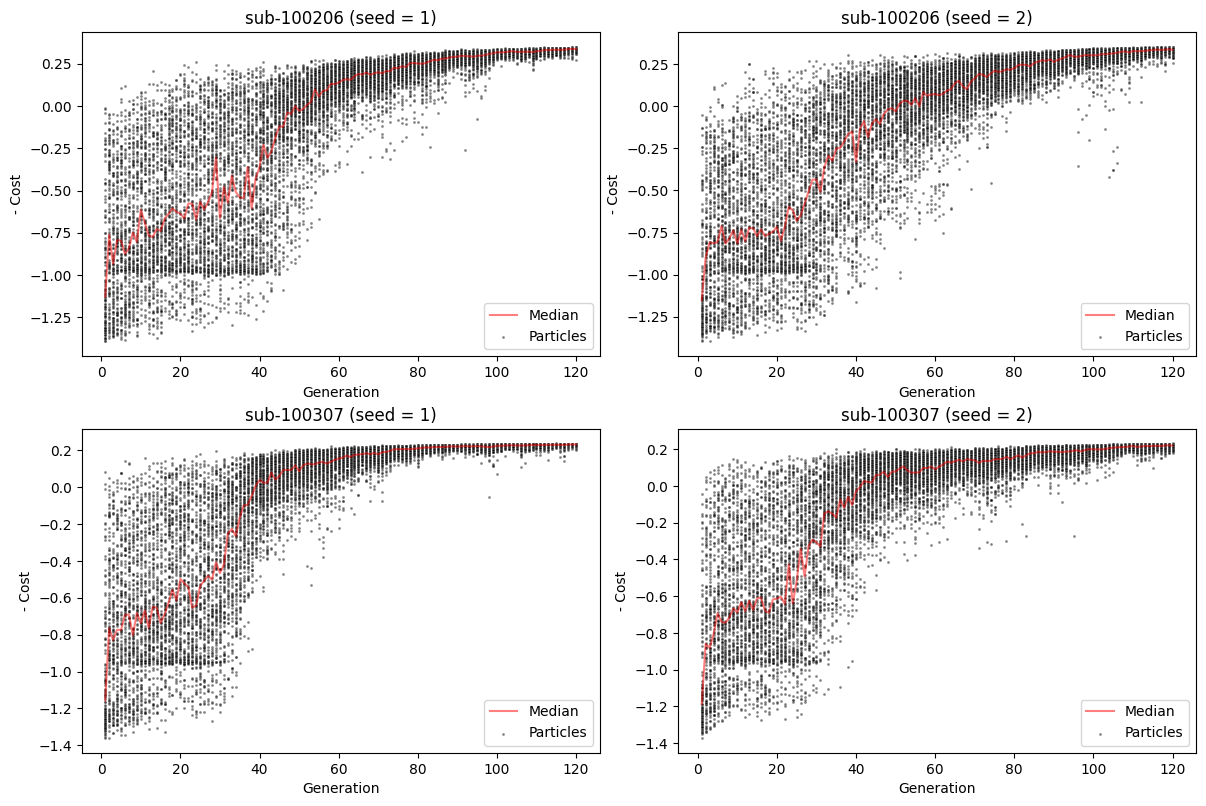

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i_sub, sub in enumerate(subjects):
    for i_seed, seed in enumerate([1, 2]):
        ax = axes[i_sub, i_seed]
        fitted_optimizers_dict[sub][seed].plot_history('-cost', ax=ax)
        ax.set_title(f'sub-{sub} (seed = {seed})')

fig.tight_layout(pad=0.5)

Each subplot shows one optimization run. We can use these plots to evaluate convergence behavior across seeds and subjects. As we can see in all runs the optimization is close to convergence, but not yet converged.

### Goodness-of-fit in the best runs across subjects

For each subject, we select the best optimization run, i.e., the run with the lowest cost across the two CMA-ES runs of that subject:

In [8]:
import numpy as np

best_optimizers = {}

for sub in subjects:
    best_cost = np.inf
    for seed in [1, 2]:
        if fitted_optimizers_dict[sub][seed].opt['cost'] < best_cost:
            best_cost = fitted_optimizers_dict[sub][seed].opt['cost']
            best_seed = seed
            best_optimizers[sub] = fitted_optimizers_dict[sub][seed]
    print(f'{sub} best run has seed = {best_seed}')
    print(fitted_optimizers_dict[sub][best_seed].opt)

100206 best run has seed = 2
index            82.000000
G                 1.412908
w_p0              0.300442
w_p1              1.212629
w_p2              1.126318
w_p3              0.287823
w_p4              0.358820
w_p5              0.466271
w_p6              0.031351
J_N0              0.110334
J_N1              0.367297
J_N2              0.250831
J_N3              0.482907
J_N4              0.001872
J_N5              0.142216
J_N6              0.104726
cost             -0.353266
+fc_corr          0.506582
-fcd_ks          -0.134565
+gof              0.372018
-fic_penalty     -0.018752
gen             113.000000
Name: 14418, dtype: float64
100307 best run has seed = 1
index            88.000000
G                 1.505496
w_p0              0.052412
w_p1              1.144096
w_p2              0.245970
w_p3              0.054260
w_p4              0.103039
w_p5              1.126802
w_p6              0.083967
J_N0              0.232139
J_N1              0.295944
J_N2              0.484

For the best run of each subject, we can then visualize:

- The regression plot comparing simulated and empirical functional connectivity (FC)
- The distribution comparison between simulated and empirical functional connectivity dynamics (FCD)

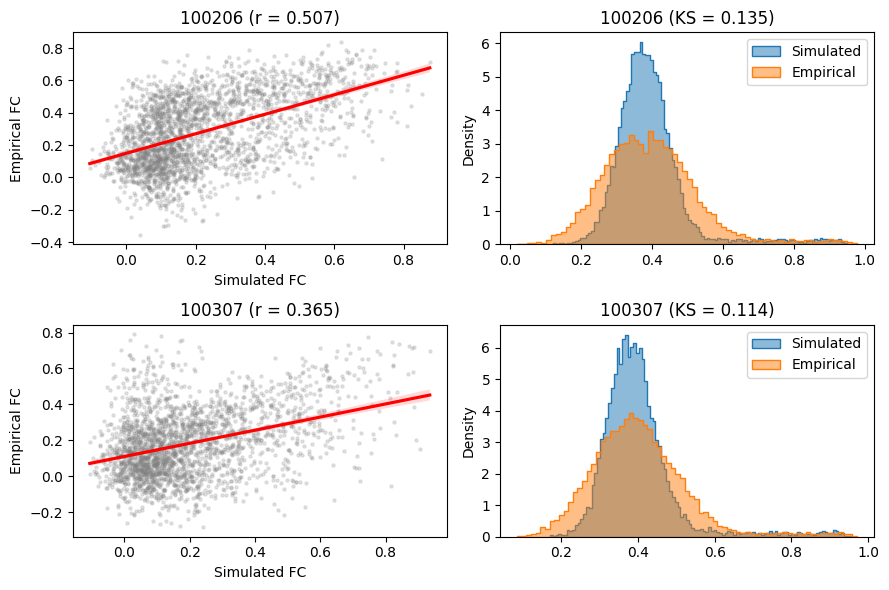

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()
for i_sub, sub in enumerate(subjects):
    # regression plot
    ax = axes[i_sub*2] 
    sns.regplot(
        x=best_optimizers[sub].problem.sim_group.sim_fc_trils[0],
        y=best_optimizers[sub].problem.emp_fc_tril,
        scatter_kws=dict(s=5, alpha=0.2, color="grey"),
        line_kws=dict(color="red"),
        ax=ax
    )
    ax.set_xlabel("Simulated FC")
    ax.set_ylabel("Empirical FC")
    # add fc_corr statistic
    ax.set_title(f'{sub} (r = {best_optimizers[sub].opt["+fc_corr"]:.3f})')
    # histograms
    ax = axes[i_sub*2+1]
    sns.histplot(best_optimizers[sub].problem.sim_group.sim_fcd_trils[0], element='step', alpha=0.5, label='Simulated', stat='density', ax=ax)
    sns.histplot(best_optimizers[sub].problem.emp_fcd_tril, element='step', alpha=0.5, label='Empirical', stat='density', ax=ax)
    ax.legend()
    # add fcd_ks statistic
    # -fcd_ks in .opt needs to be negated to have positive values
    ax.set_title(f'{sub} (KS = {-best_optimizers[sub].opt["-fcd_ks"]:.3f})')
fig.tight_layout()

### Parameters and state variables of optimal simulations

We now visualize the global coupling parameter $G$ and the regional values of $w^{p}$ and $J^{N}$ for the optimal simulations:

[Text(0, 0.5, 'sub-100206'), Text(0, 1.5, 'sub-100307')]

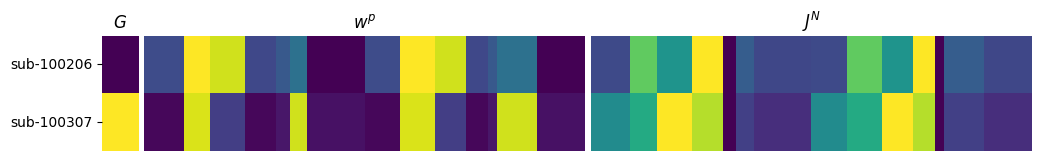

In [10]:
# create the axes
fig, axd = plt.subplot_mosaic(
    [["G"] + ["space0"] + ["w_p"] * 100 + ["space1"] + ["J_N"] * 100],
    gridspec_kw=dict(width_ratios=[10] + [1] * 202),
    figsize=(12, 1.5)
)
# plot heatmaps of parameters
sns.heatmap(
    np.array([o.problem.sim_group.param_lists['G'][0] for o in best_optimizers.values()])[:, None], 
    cbar=False, cmap='viridis', ax=axd['G']
)
axd['G'].set_title(r'$G$')
sns.heatmap(
    np.array([o.problem.sim_group.param_lists['w_p'][0] for o in best_optimizers.values()]), 
    cbar=False, cmap='viridis', ax=axd['w_p']
)
axd['w_p'].set_title(r'$w^{p}$')
sns.heatmap(
    np.array([o.problem.sim_group.param_lists['J_N'][0] for o in best_optimizers.values()]), 
    cbar=False, cmap='viridis', ax=axd['J_N']
)
axd['J_N'].set_title(r'$J^{N}$')
# aesthetics and labeling
for ax in list(axd.values())[1:]:
    ax.axis('off')
axd['G'].set_xticks([])
labels = []
for sub in subjects:
    labels.append(f'sub-{sub}')
axd['G'].set_yticklabels(labels, rotation=0)

Similarly, we can also visualize node-wise time-averaged values of a model state, such as the input to excitatory neuronal ensembles $I^E$, for each optimal simulation.

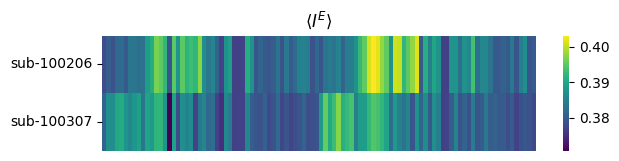

In [11]:
# take time-averaged node-wise I_E in optimal simulations
I_E_avgs = np.array([
    o.problem.sim_group.sim_states['I_E'][0, :]
    for o in best_optimizers.values()
])
# plot
fig, ax = plt.subplots(figsize=(7, 1.5))
sns.heatmap(I_E_avgs, cmap='viridis', ax=ax)
ax.set_title(r'$\langle I^E \rangle$')
labels = []
for sub in subjects:
    labels.append(f'sub-{sub}')
ax.set_yticklabels(labels, rotation=0)
ax.set_xticks([]);

## Limitations of batch optimization

Currently, batch optimization supports varying only the following attributes across the batched BNMProblem instances:

- `sc`: Structural connectivity strength matrix
- `emp_bold`: Empirical BOLD signal
- `out_dir`: Output directory

<div class="alert alert-info">
<p>
Note: When multiple optimizers are run on the same problem, their outputs are saved in the same directory and automatically numbered, e.g., `out_dir/cmaes_run-0`, `out_dir/cmaes_run-1`, etc.
</p>
</div> 

All other model and simulation parameters must be identical across batched problems. This includes, for example:

- `sc_dist`: Structural connectivity lengths (used in simulations with conduction delays)
- `sim_seed`: Random seed for generating simulation noise

In addition, all optimizers that are batched together must be:

- Subclasses of `PymooOptimizer` (e.g., `CMAESOptimizer`). Therefore, `GridOptimizer` for example is not supported.
- Of the same optimizer type across all runs, therefore it is not possible to mix e.g., CMA-ES with NSGA-II.

However, optimizer-specific properties, including `seed`, `popsize` and `n_iter` can differ between runs.

<div class="alert alert-info">
<p>
The toolbox may support varying additional features across batched problems and optimizers in the future versions.
</p>
</div>